# Séparation de sources audio


*Lorenzo Brucato - auditeur externe, M2 Mathématiques et Intelligence artificielle, Université Paris-Saclay & CentraleSupélec*

*Mohamed Amir Belkacem - Telecom Paris & ENS Saclay, Mathématiques Vision Apprentissage* 

L'objectif de ce mini-projet est d'implémenter, d'entrainer et de comparer diverses architectures de réseaux de neurones profonds pour la séparation de sources audio : nous possédons un jeu de données composé de 4000 échantillons d'audio pour l'entrainement avec une partie vocale qui interfère avec un bruit de fond sonore (donnée d'entrée) et les composantes vocale et de bruit réelles (sources cibles). L'objectif est d'extraire séparemment à partir des deux sources chacune de ces deux sources, en obtenant un signal sonore composé uniquement de la partie vocale et un signal sonore ne contenant que le bruit de fond.

Pour chacun des audios, le SNR (signal to noise ratio) indique le niveau de puissance de l'une des sources par rapport à l'autre (de -4dB lorsque le bruit est supérieur de 4dB à la composante vocale, 0dB pour l'équilibre des deux sources et jusqu'à 4dB lorsque la composante vocale prend l'avantage sur le bruit de fond)

Pour chacune des architectures analysées, nous verrons l'approche mise en place (passage par une représentation temps/fréquence du signal ou non, utilisation de la forme d'onde, architecture de convolution/déconvolution ou réseaux de neurones récurrents...) et écouterons la qualité de l'audio extrait.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mir_eval
from torchsummary import summary
import torchaudio
import IPython

from Datasets.Audiodata import *
from Models.UNet import *
from Models.UNet2 import * 
from Models.WaveUNet import *

___
### 1. Chargement des données et visualisation

*Chargement du dataset :*

In [2]:
dataset = Audiodataset(set='train_small')
print(len(dataset))

50


*Forme d'onde :*

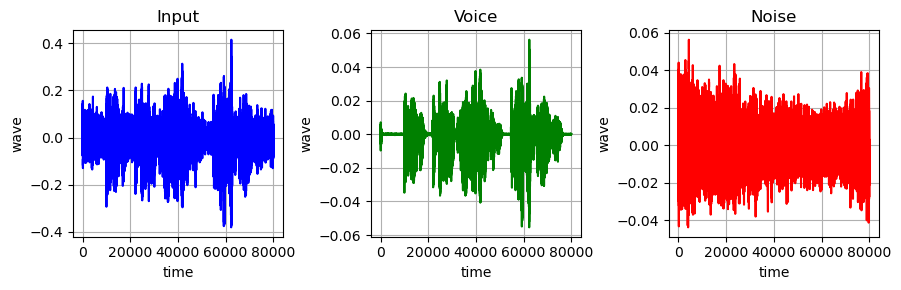

In [3]:
dataset.take_wave()
dataset.plot(0)

*Forme temps/fréquence :*

c:\Users\User\anaconda3\Lib\site-packages\torch\functional.py:704: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


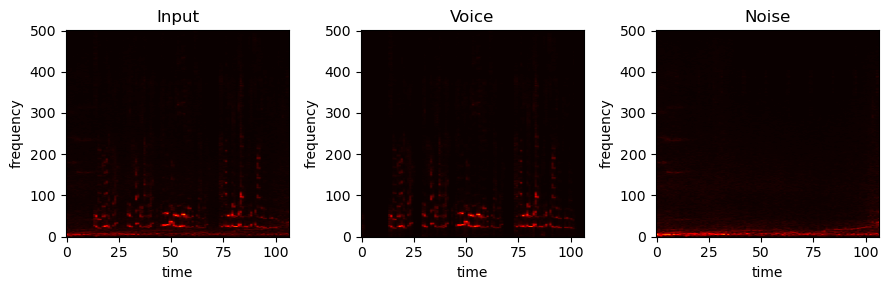

In [4]:
dataset.take_spectrogram()
dataset.plot(0)
plt.savefig('Figs/sp.png')

*Reconstruction du son depuis la représentation temps/fréquence :*

In [6]:
idx = 0
sr = 8000

dataset = Audiodataset('test', padding=True)
dataset.return_only_voice()
dataset.take_spectrogram()
X, VoiceSP = dataset[idx]

reconstruct = dataset.reconstruct(VoiceSP, idx, reference='voice')
sd.play(reconstruct.squeeze().numpy(), sr)
sd.wait()

c:\Users\User\Documents\Projets\dlts-project\Datasets\Audiodata.py:206: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:1028.)
  return torch.istft(reconstruct, n_fft=self.__n_fft, hop_length=self.__hop_length, length=original.size(1))


*Dsitrbution de la répartition des sons selon leur snr de base :*

In [15]:
snr_sum = []
for snr in range(-4, 5):
    snr_sum.append(len(Audiodataset('train', snr_filter=snr)))

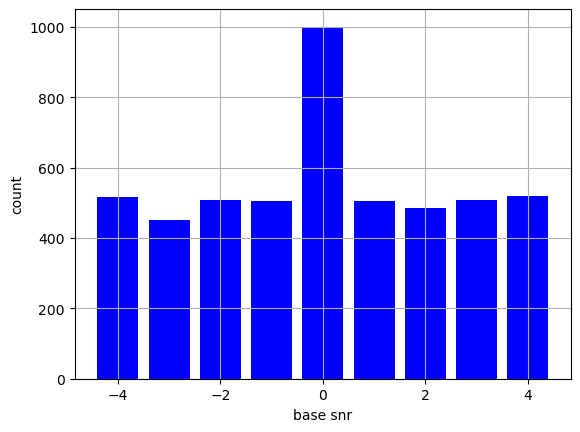

In [16]:
plt.bar(range(-4, 5), snr_sum, color='blue')
plt.xlabel('base snr')
plt.ylabel('count')
plt.grid()

___
### 2. UNet à un seul canal de sortie

Dans cette partie on implément et visualise les résultats obtenus par UNet sur la représentation temps/fréquence du modèle. L'achitecture comprend trois phases : 
- Le passage de la donnée initiale dans le domaine temps fréquence par transformation de fourier, en préservant la phase du signal
- L'entrainement d'un réseau de neurones profond par architecture UNet apprenant à générer un masque appliqué à la représentation pour extraire les deux sources du signal
- La reconstruction du signal ensuite à partir de la phase initiale et de la transformée de fourrier invers (istft)

Pour s'adapter aux dimensions de l'article et faciliter les dimensions obtenues par convolutions successives, on réalise également un padding sur les images temps/fréquence.

___
### 3. UNet à deux canaux de sortie

Au lieu d'entrainer deux modèles qui apprennent à générer les deux sources distinctes, nous nous sommes demandés si, comme pour le WaveUNet que l'on retrouve ci-après, un simple modèle ne peux pas apprendre à générer les deux masques sur la même base de paramètres. En sortie de cette variation du modèle UNet, nous retrouvons ici un masque à deux canaux pour les deux composantes du signal. L'utilisation de ce modèle en pratique nous permet d'avoir qu'un seul modèle à entrainer : 

#### 3.1 Chargement des données et initialisation du modèle

*Description des dimensions sur les couches du réseau de neurones :*

In [ ]:
model = UNet2().to(device)
summary(model, input_size = (1,512,128))

*Nombre de paramètres : ~9.82M*

In [12]:
np.sum([p.numel() for p in model.parameters()])

9824118

*Chargement des données pour l'entrainement du UNet2 :*

In [ ]:
train_dataset = Audiodataset('train',  padding=True, getitem='all')
train_dataset.take_spectrogram()

test_dataset = Audiodataset('test', padding=True, getitem='all')
test_dataset.take_spectrogram()

#### 3.2 Entraînement

In [10]:
# ==== Entrainement +20 epochs ====
model, losses = UNet2.trainModel(train_dataset, n_epochs=20, batch_size=16, learning_rate=0.0001, valid_dataset=test_dataset)

c:\Users\User\Documents\Projets\dlts-project\Models\UNet2.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  csv_path = os.path.join(SCORES_PATH_2, 'UNet2MAE.csv')


['model_10.pth', 'model_20.pth']


100%|██████████| 313/313 [00:21<00:00, 14.43it/s]


Epoch 21/40 - Train Loss: 0.0016
Valid Loss: 0.0008


100%|██████████| 313/313 [00:21<00:00, 14.60it/s]


Epoch 22/40 - Train Loss: 0.0016
Valid Loss: 0.0008


100%|██████████| 313/313 [00:21<00:00, 14.55it/s]


Epoch 23/40 - Train Loss: 0.0015
Valid Loss: 0.0008


100%|██████████| 313/313 [00:21<00:00, 14.78it/s]


Epoch 24/40 - Train Loss: 0.0015
Valid Loss: 0.0007


100%|██████████| 313/313 [00:21<00:00, 14.88it/s]


Epoch 25/40 - Train Loss: 0.0015
Valid Loss: 0.0007


100%|██████████| 313/313 [00:20<00:00, 15.14it/s]


Epoch 26/40 - Train Loss: 0.0015
Valid Loss: 0.0007


100%|██████████| 313/313 [00:20<00:00, 14.97it/s]


Epoch 27/40 - Train Loss: 0.0014
Valid Loss: 0.0007


100%|██████████| 313/313 [00:20<00:00, 15.06it/s]


Epoch 28/40 - Train Loss: 0.0014
Valid Loss: 0.0006


100%|██████████| 313/313 [00:20<00:00, 14.93it/s]


Epoch 29/40 - Train Loss: 0.0014
Valid Loss: 0.0006


100%|██████████| 313/313 [00:21<00:00, 14.35it/s]


Epoch 30/40 - Train Loss: 0.0014
Valid Loss: 0.0006


100%|██████████| 313/313 [00:21<00:00, 14.86it/s]


Epoch 31/40 - Train Loss: 0.0014
Valid Loss: 0.0006


100%|██████████| 313/313 [00:21<00:00, 14.85it/s]


Epoch 32/40 - Train Loss: 0.0014
Valid Loss: 0.0006


100%|██████████| 313/313 [00:20<00:00, 15.25it/s]


Epoch 33/40 - Train Loss: 0.0013
Valid Loss: 0.0005


100%|██████████| 313/313 [00:20<00:00, 14.97it/s]


Epoch 34/40 - Train Loss: 0.0013
Valid Loss: 0.0005


100%|██████████| 313/313 [00:20<00:00, 15.11it/s]


Epoch 35/40 - Train Loss: 0.0013
Valid Loss: 0.0005


100%|██████████| 313/313 [00:20<00:00, 14.94it/s]


Epoch 36/40 - Train Loss: 0.0013
Valid Loss: 0.0005


100%|██████████| 313/313 [00:20<00:00, 14.97it/s]


Epoch 37/40 - Train Loss: 0.0013
Valid Loss: 0.0005


100%|██████████| 313/313 [00:20<00:00, 15.07it/s]


Epoch 38/40 - Train Loss: 0.0013
Valid Loss: 0.0005


100%|██████████| 313/313 [00:20<00:00, 15.19it/s]


Epoch 39/40 - Train Loss: 0.0013
Valid Loss: 0.0005


100%|██████████| 313/313 [00:21<00:00, 14.28it/s]


Epoch 40/40 - Train Loss: 0.0012
Valid Loss: 0.0004


#### 3.3 Visualisation et analyse des résultats

*Evolution de la fonction de perte :*

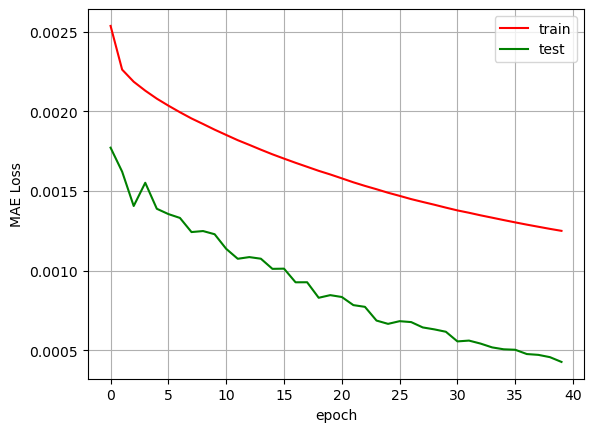

In [19]:
scores_WaveUNet = pd.read_csv('Scores/UNet2/UNet2MAE.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']
plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='test')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet2_loss.png')

___
### 4. WaveUNet

On se concentre dans cette partie sur l'implémentation d'un modèle génératif basé directement sur la forme d'onde sans passer sur la représentation temps/fréquence de la magnitude du signal.
On implémente le modèle dans des conditions similaires à celles décrites par *Stoller et al. (2018) https://arxiv.org/pdf/1806.03185*

L'architecture est un UNet sur la forme d'onde (structure encodeur/decodeur), composé de 12 layers d'encoding vers un espace de dimension réduit et 12 layers de upsampling pour retrouver le signal original masqué sur les composantes de bruit et de voix. Chaque étape de upsampling est contextualisé par une copie de l'état de downsampling à la même étape. Contrairement à un UNet classique, les auteurs proposent deux différences sur les méthodes de downsampling et de upsampling : 
- Les encodeurs réduisent la taille du signal d'entrée par décimation en supprimant de moitié les valeurs retenues de l'étape précédente
- les décodeurs réalisent un upsampling par interpolation linéaire au lieu de convolutions transposées, afin d'obtenir un meilleur lissage du signal et limiter l'apparition d'artefacts

Dans notre cas on décide de rééchantilloner le signal avec 65536 points au total sur les dix secondes d'audio (downsample avec taille en puissance de 2 pour simplifier le calcul des dimensions de convolution)

#### 4.1 Chargement des données et initialisation du modèle

In [26]:
from Models.WaveUNet import *

N_POINTS = 65536

*Taille du modèle estimé (en nombre de paramètres) : ~ 10.26M*

In [27]:
model = WaveUNet().to(device)
print(np.sum([p.numel() for p in model.parameters()]))

10263028


*Détail des dimensions sur les couches du réseau de neurones :*

In [28]:
summary(model, input_size=(1, 65536))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 24, 65536]             384
         LeakyReLU-2            [-1, 24, 65536]               0
       Downsampler-3            [-1, 24, 65536]               0
            Conv1d-4            [-1, 48, 32768]          17,328
         LeakyReLU-5            [-1, 48, 32768]               0
       Downsampler-6            [-1, 48, 32768]               0
            Conv1d-7            [-1, 72, 16384]          51,912
         LeakyReLU-8            [-1, 72, 16384]               0
       Downsampler-9            [-1, 72, 16384]               0
           Conv1d-10             [-1, 96, 8192]         103,776
        LeakyReLU-11             [-1, 96, 8192]               0
      Downsampler-12             [-1, 96, 8192]               0
           Conv1d-13            [-1, 120, 4096]         172,920
        LeakyReLU-14            [-1, 12

*Chargement des données pour WaveUNet :*

In [29]:
train_dataset = Audiodataset('train', resample_n_points=N_POINTS, getitem='concatVN')
train_dataset.take_wave()

test_dataset = Audiodataset('test', resample_n_points=N_POINTS, getitem='concatVN')
test_dataset.take_wave()

#### 4.2 Entraînement

On utilise un batch size de 16 seulement (haute demande en ressources mémoires durant les étapes de downsampling) et un learning rate initial de 0.0001 pour l'optimiseur Adam comme décris dans l'article pour le modèle baseline :

In [30]:
# ==== Entrainement +20 epochs ====
# model, losses = WaveUNet.trainModel(train_dataset, n_epochs=20, batch_size=16, learning_rate=0.0001, valid_dataset=test_dataset)

c:\Users\User\Documents\Projets\dlts-project\Models\WaveUNet.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(PATH, f'mode

Epoch 41/60 - Train Loss : 0.000008
Valid Loss : 0.000007


100%|██████████| 313/313 [01:35<00:00,  3.29it/s]


Epoch 42/60 - Train Loss : 0.000008
Valid Loss : 0.000007


100%|██████████| 313/313 [01:34<00:00,  3.31it/s]


Epoch 43/60 - Train Loss : 0.000008
Valid Loss : 0.000007


100%|██████████| 313/313 [01:34<00:00,  3.33it/s]


Epoch 44/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:34<00:00,  3.33it/s]


Epoch 45/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:35<00:00,  3.29it/s]


Epoch 46/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:35<00:00,  3.29it/s]


Epoch 47/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:36<00:00,  3.24it/s]


Epoch 48/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:38<00:00,  3.18it/s]


Epoch 49/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:36<00:00,  3.24it/s]


Epoch 50/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:36<00:00,  3.24it/s]


Epoch 51/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:36<00:00,  3.23it/s]


Epoch 52/60 - Train Loss : 0.000007
Valid Loss : 0.000006


100%|██████████| 313/313 [01:39<00:00,  3.16it/s]


Epoch 53/60 - Train Loss : 0.000007
Valid Loss : 0.000007


100%|██████████| 313/313 [01:36<00:00,  3.24it/s]


Epoch 54/60 - Train Loss : 0.000006
Valid Loss : 0.000007


100%|██████████| 313/313 [01:37<00:00,  3.21it/s]


Epoch 55/60 - Train Loss : 0.000006
Valid Loss : 0.000006


100%|██████████| 313/313 [01:44<00:00,  2.98it/s]


Epoch 56/60 - Train Loss : 0.000006
Valid Loss : 0.000006


100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Epoch 57/60 - Train Loss : 0.000006
Valid Loss : 0.000006


100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


Epoch 58/60 - Train Loss : 0.000006
Valid Loss : 0.000006


100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Epoch 59/60 - Train Loss : 0.000006
Valid Loss : 0.000006


100%|██████████| 313/313 [01:45<00:00,  2.95it/s]


Epoch 60/60 - Train Loss : 0.000006
Valid Loss : 0.000006


#### 4.3 Evolution de la loss (MSE error) : 

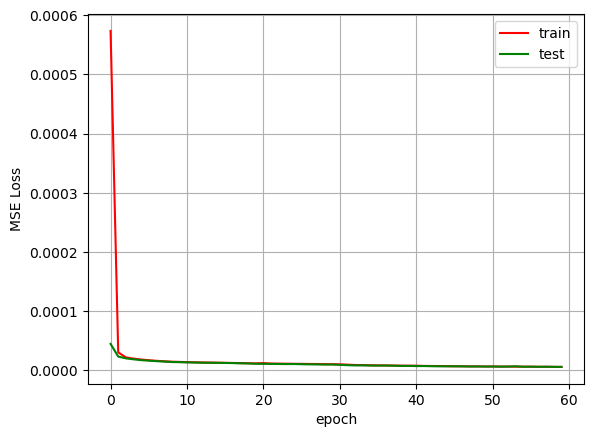

In [32]:
scores_WaveUNet = pd.read_csv('Scores/WaveUNet/WaveUNetMSE.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']
plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='test')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.savefig('Figs/WaveUNetLoss.png')

#### 4.4 Ecoute sur une donnée de test

Visualisation et écoute de la performance du modèle génératif :

In [46]:
idx = 0

In [47]:
X, Y = test_dataset[idx]
model = WaveUNet()
model.load_state_dict(torch.load('Paths/WaveUNet/model_60.pth'))
output = model(X.unsqueeze(0))

C:\Users\User\AppData\Local\Temp\ipykernel_19464\576456150.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Paths/WaveUNet/model_60.pth'

*Comparaison Voix originale/Voix générée :*

C:\Users\User\AppData\Local\Temp\ipykernel_19464\4088492110.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_19464\4088492110.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


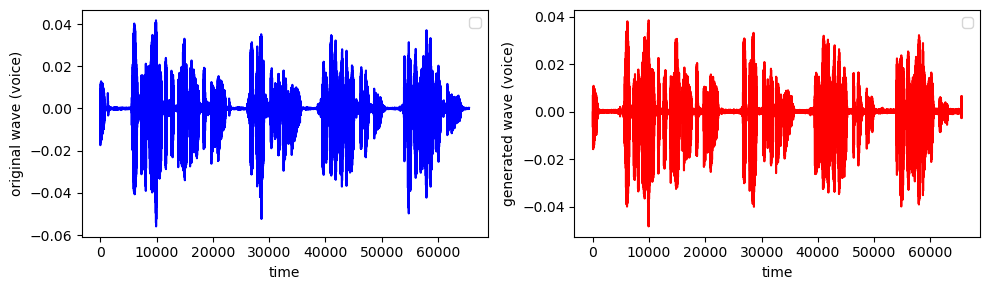

In [48]:
Vtrue = Y[0,:].squeeze().detach().numpy()
Vpred = output[:,0,:].squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Vtrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(Vpred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetVoiceEx.png')

*Comparaison Bruit original/Bruit généré :*

C:\Users\User\AppData\Local\Temp\ipykernel_19464\2963105354.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_19464\2963105354.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


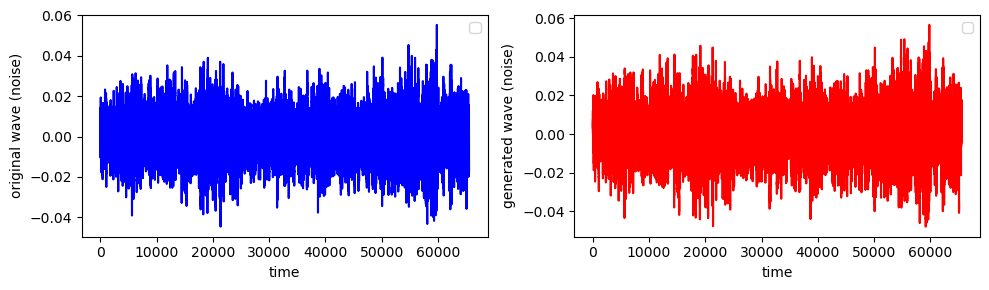

In [49]:
Ntrue = Y[1,:].squeeze().detach().numpy()
Npred = output[:,1,:].squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Ntrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(Npred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetNoiseEx.png')

*Ecoute du son original (bruité)/voix originale/voix générée/bruit original/bruit généré :*

In [50]:
# son original
sd.play(X.squeeze().detach().numpy(), N_POINTS/10)
sd.wait()

In [51]:
# voix originale
sd.play(Vtrue, N_POINTS/10)
sd.wait()

In [52]:
# voix générée (extraite du son original)
sd.play(2*Vpred, N_POINTS/10)
sd.wait()

In [53]:
# bruit original
sd.play(Ntrue, N_POINTS/10)
sd.wait()

In [54]:
# bruit généré (extrait du son original)
sd.play(Npred, N_POINTS/10)
sd.wait()

### 4.5 Comparaison selon le SNR des données test 

*SNR estimé à partir du bruit résiduel :*

In [55]:
model.eval()
model.to(device)

SNRV = []
SNRN = []

criterion = torch.nn.MSELoss()

for snr in tqdm(range(-4, 5)):

    test_dataset = Audiodataset('test', resample_n_points=N_POINTS, snr_filter=snr, getitem='concatVN')
    test_dataset.take_wave()    
    test_dataloader = DataLoader(test_dataset, batch_size=16)

    numsV = 0.0
    denomsV = 0.0
    numsN = 0.0
    denomsN = 0.0

    for X, Y in test_dataloader:

        X, Y = X.to(device), Y.to(device)
        output = model(X)
        
        Vpred = output[:,0,:]
        Npred = output[:,1,:]
        
        numsV += torch.sum((Y[:,0,:]**2).squeeze()).item()
        denomsV += torch.sum( ((Y[:,0,:] - Vpred)**2).squeeze() ).item()

        numsN += torch.sum((Y[:,1,:]**2).squeeze()).item()
        denomsN += torch.sum( ((Y[:,1,:] - Npred)**2).squeeze() ).item()

    SNRV.append(10*np.log10(numsV/denomsV))
    SNRN.append(10*np.log10(numsN/denomsN))

100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


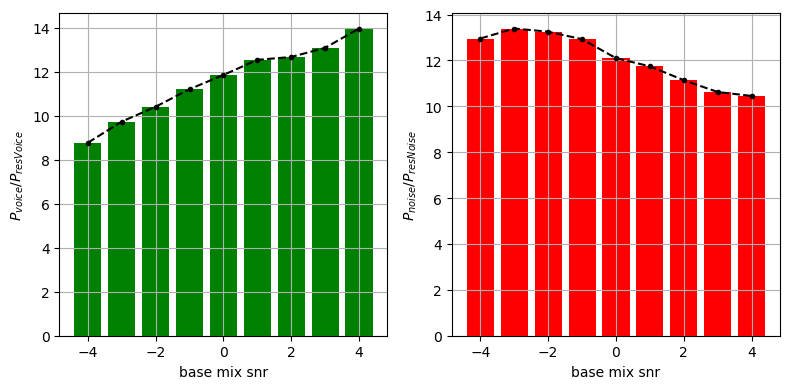

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
ax.bar(range(-4, 5), SNRV, color='green')
ax.plot(range(-4, 5), SNRV, color='black', marker='.', linestyle='--')
ax.grid()
ax.set_ylabel('$P_{voice}/P_{resVoice}$')
ax.set_xlabel('base mix snr')

ax = axs[1]
ax.bar(range(-4, 5), SNRN, color='red')
ax.plot(range(-4, 5), SNRN, color='black', marker='.', linestyle='--')
ax.grid()
ax.set_ylabel('$P_{noise}/P_{resNoise}$')
ax.set_xlabel('base mix snr')

plt.tight_layout()
plt.savefig('Figs/WaveUNetSNR.png')